<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/mosh_2_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load Saving BERT embedding...
0:	learn: 0.5970735	test: 0.5891549	best: 0.5891549 (0)	total: 1.43s	remaining: 23m 43s
100:	learn: 0.6280781	test: 0.6177354	best: 0.6177354 (100)	total: 1m 53s	remaining: 16m 49s
200:	learn: 0.6432990	test: 0.6342701	best: 0.6343112 (198)	total: 3m 39s	remaining: 14m 33s
300:	learn: 0.6514894	test: 0.6434242	best: 0.6434870 (297)	total: 5m 20s	remaining: 12m 25s
400:	learn: 0.6570422	test: 0.6495123	best: 0.6495123 (400)	total: 7m 3s	remaining: 10m 32s
500:	learn: 0.6633503	test: 0.6566644	best: 0.6566644 (500)	total: 8m 41s	remaining: 8m 39s
600:	learn: 0.6687031	test: 0.6620237	best: 0.6620817 (596)	total: 10m 20s	remaining: 6m 52s
700:	learn: 0.6746658	test: 0.6679681	best: 0.6679681 (700)	total: 12m	remaining: 5m 7s
800:	learn: 0.6805495	test: 0.6739826	best: 0.6739826 (800)	total: 13m 39s	remaining: 3m 23s
900:	learn: 0.6853893	test: 0.6788154	best: 0.6788154 (900)	total: 15m 14s	remaining: 1m 40s
999:	learn: 0.6894705	test: 0.6829242	best: 0.682924

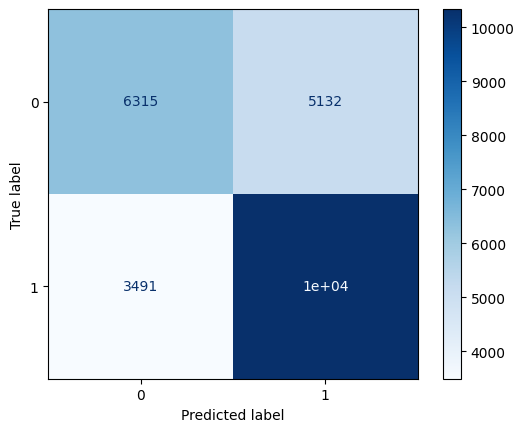

F1-score (macro): 0.6499994165645184
Precision (macro): 0.6561487532378399
Recall (macro): 0.6496344537246935


In [6]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # избегаем конфликта с TensorFlow

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from tqdm import tqdm
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Загружаем данные
data = pd.read_csv('all_dataset_processed_2_cat.csv')


numeric_features = ['Spell_Errors', 'Slang_Count', 'Emoji_Count', 'Punctuation_Count', 'Word_Count', 'Avg_Word_Length', 'Comment_Length', 'Ends_With_Punct', 'Has_Slang', 'Has_Spell_Errors']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_features]).astype(int)

# BERT эмбеддинги
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

bert_file = 'bert_embeddings.npy'

if os.path.exists(bert_file):
    print("Load Saving BERT embedding...")
    bert_features = np.load(bert_file)
else:
    print("Generate BERT embedding...")
    bert_embeddings = []
    for comment in tqdm(data['Comment_processed'], desc="BERT embedding"):
        try:
            emb = get_bert_embedding(comment)
        except Exception:
            emb = np.zeros(768)
        bert_embeddings.append(emb)

    bert_features = np.vstack(bert_embeddings)
    np.save(bert_file, bert_features)  # Сохраняем в файл


# Объединение признаков
X = np.hstack([bert_features, scaled_features])

y = data['Age_Group'].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Обучение CatBoost
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 6,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'random_seed': 42,
    'verbose': 100,
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'early_stopping_rounds': 50
}

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

cat_features = list(range(bert_features.shape[1], X.shape[1]))  # Индексы категориальных признаков

cb_clf = CatBoostClassifier(**catboost_params)
cb_clf.fit(X_train, y_train,
           eval_set=(X_res, y_res),
           use_best_model=True)

# Предсказание и оценка
y_pred = cb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Кросс-валидация
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_scores = cross_val_score(cb_clf, X, y, cv=cv, scoring='f1_macro')

print(f'Cross-valid F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# # Подбор гиперпараметров с помощью GridSearchCV
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [150, 200, 250],
# }

# grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1_macro', cv=cv)
# grid_search.fit(X_train, y_train)

# print(f'Best parms: {grid_search.best_params_}')
# print(f'Best F1-score: {grid_search.best_score_:.4f}')

# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

y_pred = cb_clf.predict(X_test)
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))